<details>
   <summary>Metadata</summary> 
    title: "E-TRAINEE HELIOS++ exercise for point cloud change analysis"<br />
    description: "This is an exercise in the second theme within the 3D/4D Geographic Point Cloud Time Series Analysis module."<br />
    dateCreated: 2022-08<br />
    authors: Mark Searle<br />
    contributors: Katharina Anders, Bernhard Höfle, Hannah Weiser <br />
    estimatedTime: 1.5 hrs
</details>

# Exercise: Virtual Laser Scanning in HELIOS++ for Point Cloud Change Analysis

In this excercise we will be conducting an experiment of surface change analysis using UAV-borne laser scanning (ULS) point clouds and virtually generated airborne laser scanning (ALS) point coulds. Our area of interest (AOI) is a rock glacier in Austria of which UAV point clouds have been acquired repeatedly by the [3DGeo Research Group](https://www.geog.uni-heidelberg.de/3dgeo/index.html) in Heidelberg over the past years. By analysing and comparing the point clouds from different points in time (epochs), it is possible to analyse the movement of the rock glacier.

The aim of this exercise is to analyse the difference in surface change detection when acquiring the rock glacier using ULS vs ALS. ALS point clouds generally have lower point densities and therefore lower spatial resolutions as well as lower overall ranging accuracy and may therefore lead to unwanted noise in the change detection. However, ALS can prove to be a more cost-efficient method due to the large coverage areas. For many regions, ALS datasets are available online via national inventory databases. Therefore the option of using ALS data may be considered if the acquired data meets the requirements for any given analysis. Virtual laser scanning (VLS) is a valuable tool that can help us determine whether point clouds from certain LiDAR acquisitions meet the analysis requirements. In this case, we will be analysing whether ALS point clouds of the rock glacier in Austria would deliver valuable results when applying a rudimentary method of surface change analysis.

To do so, we will first perform surface change detection between our two epochs of ULS data. Then, we will generate ALS data for each epoch, using the Heidelberg LiDAR Operations Simulator (HELIOS++) and the ULS data as the 3D models which are recorded by the virtual airborne laser scanner. After performing surface change analysis on the ALS data for each epoch, we can compare the results of the ULS and the ALS surface change analysis and determine if there is a noteworthy difference in the results.

The data for the exercise is located in the directory `ahk` of the course data repository.

In the following cell, we import the necessary libraries.

In [1]:
# Import required modules
from pathlib import Path
import time
import pdal
import matplotlib.pyplot as plt
import matplotlib
from ipywidgets import interact
import numpy as np
import rasterio as rio
import pyhelios
from pyhelios import SimulationBuilder
from pyhelios.util import flight_planner, scene_writer

We also create a folder structure for our HELIOS++ inputs.

Important for this exercise: All data paths need to be indicated with forward slashes.

In [2]:
Path('data/scenes').mkdir(parents=True, exist_ok=True)
Path('data/sceneparts').mkdir(parents=True, exist_ok=True)
Path('data/surveys').mkdir(parents=True, exist_ok=True)

### 1. ULS data surface change analysis
The ULS data can be seen as the 'ground truth' data for the rock glacier. By conducting a change detection analysis on the ULS data, we get a good estimate of the surface change that occurred between 2020 and 2021.

**Method:**
For a rudementary form of change detection we will convert both point clouds to height rasters and calculate the difference between the rasters.

Please indicate the path of the ULS datasets at points T1 and T2 below.

In [3]:
uls_t1 = 'path-to-data/ahk/ahk_2020_uls.laz'
uls_t2 = 'path-to-data/ahk/ahk_2021_uls.laz'

**1.1 Create raster from ULS 2020:**

In [4]:
uls_t1_dtm = uls_t1.replace('.laz', '_dtm_1m.tif')

In [5]:
json_dtm = """[
    "%s",
    {
        "type":"filters.outlier",
        "method":"statistical",
        "mean_k":12,
        "multiplier":2.2
    },
    {
        "type":"filters.range",
        "limits":"Classification![7:7]"
    },
    {
        "type":"writers.gdal",
        "filename": "%s",
        "output_type":"min",
        "gdaldriver":"GTiff",
        "resolution":1.0,
        "window_size":8
    }
]""" % (uls_t1, uls_t1_dtm)


In [6]:
pipeline = pdal.Pipeline(json_dtm)
exe = pipeline.execute()

*1.1.1 Getting raster dimensions:*

For this we will use the python package [rasterio](https://pypi.org/project/rasterio/), which allows us to read and write TIF files.

In [7]:
# getting raster dimensions so the dimensions of the second raster can be adapted accordingly

with rio.open(uls_t1_dtm) as src:
    uls_t1_data = src.read(1, masked=True)
    t1_tf = src.transform
    t1_bounds = src.bounds
    dsm_meta = src.profile
    width= src.width
    height = src.height
    
origin_left, origin_bottom, origin_right, origin_top = t1_bounds
dsm_width = dsm_meta['width']
dsm_height = dsm_meta['height']

**1.2 Create raster from ULS 2021:**

In [8]:
uls_t2_dtm = uls_t2.replace('.laz', '_dtm_1m.tif')

In [9]:
json_dtm = """[
    "%s",
    {
        "type":"writers.gdal",
        "filename": "%s",
        "output_type":"min",
        "gdaldriver":"GTiff",
        "resolution":1.0,
        "window_size":8,
        "origin_x":"%.3f",
        "origin_y":"%.3f",
        "width":"%i",
        "height":"%i"
    }
]""" % (uls_t2, uls_t2_dtm, origin_left, origin_bottom, dsm_width, dsm_height)

In [10]:
pipeline = pdal.Pipeline(json_dtm)
exe = pipeline.execute()

**1.3 Calculate difference of rasters:**


In [11]:
with rio.open(uls_t1_dtm) as src:
    uls_t1_data = src.read(1, masked=True)
    
with rio.open(uls_t2_dtm) as src:
    uls_t2_data = src.read(1, masked=True)

In [12]:
uls_diff = uls_t1_data - uls_t2_data

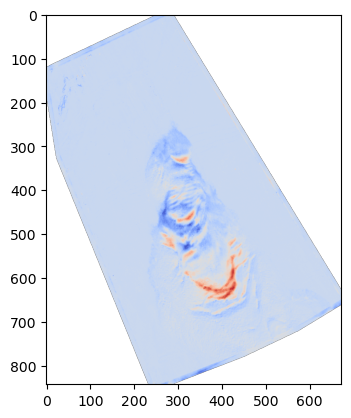

In [13]:
plt.imshow(uls_diff, cmap='coolwarm')
plt.show()

We can clearly identify the rock glacier by the areas of surface change that we see in the image. Let's save the ULS surface change to a file.

In [14]:
uls_diff_file = 'uls_diff.tif'

with rio.open(uls_diff_file, 'w', **dsm_meta) as ff:
    ff.write(uls_diff, 1)

### 2. Generate ALS data

Using [HELIOS++](https://github.com/3dgeo-heidelberg/helios), we will now run two virtual laser scanning acquisitions over our 3D model of the rock glacier at both points in time (2020 & 2021). We will be conducting airborne laser scanning (ALS) acquisitions. Comparing the two virtual ALS datasets will give us an estimate for the change we would have detected in the rock glacier if we had flown two ALS acquisitions. Comparing the detected change by ALS with the change by ULS will indicate the precision/accuracy of the ALS change detection.

To make yourself familiar with HELIOS++ and how it works, please consult the [wiki](https://github.com/3dgeo-heidelberg/helios).

**2.1 Create HELIOS++ scenes**

First we must create the XML scenes for our two simulations. The scene files allow you to define the 3d models which will be loaded into HELIOS++ and recorded by the virtual laser scanner. You can read up on scene files in the [HELIOS++ wiki entry](https://github.com/3dgeo-heidelberg/helios/wiki/Scene). If you are not familiar with XML files it might also be sensible to have a look at the [XML wikipedia article](https://de.wikipedia.org/wiki/Extensible_Markup_Language). Each component of a HELIOS++ simulation is defined in an XML file.

In our case, the scenes will consist of one TIF file each, representing the surface of the rock glacier at the two points in time. We will write the scenes using the scene_writer, which is part of the util-sub package of pyhelios. You can read up on the scene writer in the [corresponding wiki entry](https://github.com/3dgeo-heidelberg/helios/wiki/pyhelios-%F0%9F%90%8D-The-util-subpackage#the-scene-writer).

*2.1.1 Create sceneparts from DTMs*

We first create python instances of out two sceneparts, the DTMs of the rock glacier in 2020 and 2021. To do so, we use the `create_scenepart_tiff` function which is demonstrated in the [corresponding wiki entry](https://github.com/3dgeo-heidelberg/helios/wiki/pyhelios-%F0%9F%90%8D-The-util-subpackage#the-scene-writer). Before that, we are writing a material file which we will assign to the GeoTIFFs.
Click the solution below if you need help.

In [15]:
path_mtl = 'data/sceneparts/ground.mtl'

mtl_content = """# Blender MTL File: 'None'
# Material Count: 1

newmtl terrain
Ns 0
Kd 0.2 0.5 0.2
d 1
illum 2
helios_isGround true"""

with open(path_mtl, 'w') as mtl_file:
    mtl_file.write(mtl_content)

In [ ]:
sp1 = scene_writer.create_scenepart_tiff()

sp2 = scene_writer.create_scenepart_tiff()

<details>
    <summary>Solution</summary>
  
```python
sp1 = scene_writer.create_scenepart_tiff(uls_t1_dtm,
                               matfile=path_mtl,
                               matname='terrain')

sp2 = scene_writer.create_scenepart_tiff(uls_t2_dtm,
                               matfile=path_mtl,
                               matname='terrain')
```
</details>

*2.1.2 Build scenes*

Next, we build our two scenes. Each scene contains one of the sceneparts created in the previous step, corresponding to the rock glacier in 2020 and 2021. The `build_scene` function allows us to do so. Click the solution below if you need help.

In [ ]:
scenes = [scene_writer.build_scene(), 
          scene_writer.build_scene()]

<details>
    <summary>Solution</summary>
  
```python
scenes = [scene_writer.build_scene(scene_id='uls_t1', name='Rock Glacier T1', sceneparts=[sp1]), 
          scene_writer.build_scene(scene_id='uls_t2', name='Rock Glacier T2', sceneparts=[sp2])]
```
</details>

*2.1.3 Write scenefiles*

Finally, we write the scenes to XML files which can be read by HELIOS++ to execute the simulations. We give a name to each file and write the content of the scenes we built in the previous step to the files. Click the solution below if you need help.

In [ ]:
scenefiles = ['', '']

for i in range(2):
    pass

<details>
    <summary>Solution</summary>
  
```python
scenefiles = ['data/scenes/scene_t1.xml', 'data/scenes/scene_t2.xml']

for i in range(2):
    with open(scenefiles[i], 'w') as f:
        f.write(scenes[i])
```
</details>

**2.2 Create HELIOS++ surveys**

The [HELIOS++ XML survey file](https://github.com/3dgeo-heidelberg/helios/wiki/Survey) defines the movement and type of scanner used, as well as the settings of the scanner and the scene to be scanned. In the cell below you can choose an appropriate scanning platform and scanner model for our acquisitions. You can also choose the settings for the surveys, as well as names for the surveys.

Take a look at the wiki page for the [scanner](https://github.com/3dgeo-heidelberg/helios/wiki/Scanners) and the [platform](https://github.com/3dgeo-heidelberg/helios/wiki/Platforms) to help you choose the correct platform and scanner ids for ALS acquisitions. The possible scanner settings can be read from the entries for each scanner in the scanner xml file. Click the solution below if you need help.

In [ ]:
scanner_xml = 'data/scanners_als.xml'
platform_xml = 'data/platforms.xml'
scanner_id = ''
platform_id = ''
pulse_freq = 0
scan_freq = 0
flight_v = 0
alt = 0
scan_angle = 0
surveys = ["", ""]

<details>
    <summary>Possible solution</summary>
  
```python
scanner_xml = 'data/scanners_als.xml'
platform_xml = 'data/platforms.xml'
scanner_id = 'leica_als50-ii'
platform_id = 'sr22'
pulse_freq = 100000
scan_freq = 90
flight_v = 60
alt = 4000
scan_angle = 30
surveys = ['data/surveys/als_t1.xml', 'data/surveys/als_t2.xml']
```
</details>

**Explanation:** The specifications above mean that we will use the Leica ALS 50-ii which will be mounted on our airborne laser scanning mount, the SR-22. The scanner will operate at a pulse frequency of 100000 Hz and a scan frequency of 90 Hz at a scan angle of +- 30°. The aicraft will be flying at an altitude of 4000 m (above sea level) with a speed of 60 m/s.

You will find the ALS 50-ii and its specifications in the file [data/scanners_als.xml](https://github.com/3dgeo-heidelberg/helios/blob/main/python/pyhelios/data/scanners_als.xml). The SR-22 mount can be found in the file [data/platforms_als.xml](https://github.com/3dgeo-heidelberg/helios/blob/main/python/pyhelios/data/platforms.xml).

***

*2.2.1 Set flight paths*

To define our surveys we must determine the flight path of the aircraft. Excecute the following code to set the two flight passes manually.

In [20]:
%matplotlib qt
def tellme(s):
    plt.title(s, fontsize=12)
    plt.draw()
    
n_pos = 4

plt.figure()

zoom_out = 600

plt.imshow(uls_diff, cmap='coolwarm')

plt.axis('equal')

ax = plt.gca()
ax.set_xlim([-zoom_out, np.shape(uls_diff)[1]+zoom_out])
ax.set_ylim([np.shape(uls_diff)[0]+zoom_out, -zoom_out])

tellme('Now you may select the trajectory of the aircraft carrying the virtual laser scanner.')

plt.waitforbuttonpress()

while True:
    pt = []
    while len(pt) < n_pos:
        tellme(f'Please choose {n_pos} four positions with the mouse.')
        pt = np.asarray(plt.ginput(n_pos, timeout=-1))
    line_1 = plt.plot([pt[0][0], pt[1][0]], [pt[0][1], pt[1][1]], label='Pass 1', color='steelblue')
    line_2 = plt.plot([pt[2][0], pt[3][0]], [pt[2][1], pt[3][1]], label='Pass 2', color='firebrick')
    
    ar_length = 10000
    arrow_1 = plt.arrow(pt[1][0], pt[1][1], -(pt[0][0]-pt[1][0])/ar_length, (pt[1][1]-pt[0][1])/ar_length, head_width=50, edgecolor='none', facecolor='steelblue')
    arrow_2 = plt.arrow(pt[3][0], pt[3][1], -(pt[2][0]-pt[3][0])/ar_length, (pt[3][1]-pt[2][1])/ar_length, head_width=50, edgecolor='none', facecolor='firebrick')
    plt.legend()
    
    tellme('Happy?\nKeypress for "Yes", mouseclick for "No"')

    if plt.waitforbuttonpress(timeout=-1):
        plt.close()
        break
    
    ax = plt.gca()

    for art in ax.get_children():
        if isinstance(art, matplotlib.patches.FancyArrow) or isinstance(art, matplotlib.lines.Line2D):
            art.remove()

x1, y1 = t1_tf * (pt[0][0], pt[0][1])
x2, y2 = t1_tf * (pt[1][0], pt[1][1])
x3, y3 = t1_tf * (pt[2][0], pt[2][1])
x4, y4 = t1_tf * (pt[3][0], pt[3][1])
print(f'You have chosen your flight lines.\nCoordinates P1: x={x1}, y={y1}\nCoordinates P2: x={x2}, y={y2}\nCoordinates P2: x={x3}, y={y3}\nCoordinates P2: x={x4}, y={y4}')

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


You have chosen your flight lines.
Coordinates P1: x=652595.6256312063, y=5189474.530777838
Coordinates P2: x=652936.5498904843, y=5188693.376775948
Coordinates P2: x=653167.6207773283, y=5188807.137067486
Coordinates P2: x=652758.5116661948, y=5189538.994943042


*2.2.2 Write survey files*

Now we can write the selected scan lines to our survey files. In the step below, we write the string containing the simulation legs, that define the movement of the scanner and the settings at each point in time. Have a look at the [wiki entry on simulation legs](https://github.com/3dgeo-heidelberg/helios/wiki/Survey#leg-definition) to find out more.

In our case, we take the points selected in the plot in the last cell.

In [21]:
legs = ''
active = True
for i in range(4):
    if i % 2 == 0:
        active = True
    else:
        active = False
    
    x, y = t1_tf * (pt[i][0], pt[i][1])
    
    legs += f'''
    <leg stripId="0">
            <platformSettings x="{x}" y="{y}" template="platform_als"/>
            <scannerSettings template="scanner_als" active="{active}"/>
    </leg>'''

The main survey content contains templates for the scan settings as well as the platform settings which can then be applied to each leg. We also define the name of the platform to be used in the survey as well as the scanner model and the scene.

In [22]:
survey_content = f'''<?xml version="1.0" encoding="UTF-8"?>
<document>
    <platformSettings id="platform_als" movePerSec_m="{flight_v}" z="{alt}" />
    <scannerSettings active="true" id="scanner_als" pulseFreq_hz="{pulse_freq}" scanAngle_deg="{scan_angle}" scanFreq_hz="{scan_freq}" trajectoryTimeInterval_s="0.01"/>
    <survey name="als_rock_glacier" platform="{platform_xml}#{platform_id}" scanner="{scanner_xml}#{scanner_id}" scene="">
    <FWFSettings beamSampleQuality="5" winSize_ns="1.5"/>
    {legs}
    </survey>
</document>

''' 

To distinguish our surveys from each other we must assign them each their corresponding scene file and a unique survey id. In this case `als_rock_glacier_t1` and `als_rock_glacier_t2`.

In [23]:
for i in range(2):
    scene_name = scenefiles[i] + '#' + f'uls_t{i+1}'
    survey_id = f'als_rock_glacier_t{i+1}'
    
    print(f'Writing survey...\nFilename: {surveys[i]}\nSurvey ID: {survey_id}\nScene: {scene_name}\n')
    
    with open(surveys[i], 'w') as f:
        f.write(survey_content.replace('scene=""', f'scene="{scene_name}"').replace(
        'als_rock_glacier', survey_id))

Writing survey...
Filename: data/surveys/als_t1.xml
Survey ID: als_rock_glacier_t1
Scene: data/scenes/scene_t1.xml#uls_t1

Writing survey...
Filename: data/surveys/als_t2.xml
Survey ID: als_rock_glacier_t2
Scene: data/scenes/scene_t2.xml#uls_t2



**2.3 Run HELIOS++ surveys**

Next, we run our simulations, using the HELIOS++ python bindings, `pyhelios`. There is a [wiki entry](https://github.com/3dgeo-heidelberg/helios/wiki/Python-bindings-%F0%9F%90%8D-Getting-started) designated to pyhelios where you can read up on the basic usage.

*2.3.1 Set HELIOS++ environment*

First we set the desired logging verbosity as well as a randomness seed.

In [24]:
# Set logging.
#pyhelios.loggingSilent()
#pyhelios.loggingQuiet()
pyhelios.loggingDefault()
#pyhelios.loggingVerbose()
#pyhelios.loggingVerbose2()

# Set seed for random number generator.
pyhelios.setDefaultRandomnessGeneratorSeed('123')

*2.3.2 Build simulations and run surveys*

Now we build and run the simulation for each of the two survey files we created in the previous steps. The for-loop iterates over both our simulations and builds and executes them consecutively.

**Note:** If you are running jupyter from a console window you can watch the logging output of the HELIOS++ simulations there.

In [25]:
outfiles = []

for survey in surveys:
    # use SimulationBuilder to configure simulation
    simB = SimulationBuilder(str(survey), ['assets/'], 'output/')
    simB.setLasOutput(True)
    simB.setZipOutput(True)
    simB.setCallbackFrequency(10000)
    
    # build the simulation
    sim = simB.build()
    
    # Start the simulation.
    start_time = time.time()
    sim.start()

    if sim.isStarted():
        print(f'Simulation has started!\nSurvey Name: {sim.sim.getSurvey().name}\n{sim.sim.getScanner().toString()}')

    while sim.isRunning():
        duration = time.time()-start_time
        mins = duration // 60
        secs = duration % 60
        print('\r'+f'Simulation has been running for {int(mins)} min and {int(secs)} sec. Please wait.', end='')
        time.sleep(1)

    if sim.isFinished():
        print('\n'+'Simulation has finished!')
    
    output = sim.join()
        
    outfiles.append(output.filepath)

SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 8.190364899928682 seconds
Simulation has started!
Survey Name: als_rock_glacier_t1
Scanner: leica_als50-ii
Device[0]: leica_als50-ii
	Average Power: 4 W
	Beam Divergence: 0.22 mrad
	Wavelength: 1064 nm
	Visibility: 23 km

Simulation has been running for 0 min and 6 sec. Please wait.
Simulation has finished!
SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 8.661293999990448 seconds
Simulation has started!
Survey Name: als_rock_glacier_t2
Scanner: leica_als50-ii
Device[0]: leica_als50-ii
	Average Power: 4 W
	Beam Divergence: 0.22 mrad
	Wavelength: 1064 nm
	Visibility: 23 km

Simulation has been running for 0 min and 6 sec. Please wait.
Simulation has finished!


### 3. ALS data surface change analysis

The HELIOS++ acquisitions have left us with two point clouds, representing ALS acquisitions of the rock glacier in 2020 and 2021 respectively. The filenames of the ouptut were stored in the `outfiles` python list after completion of each simulation.

As we did for the ULS data, we will now convert both point clouds to height rasters, and calculate the difference of the two rasters as a rudimentary form of surface change analysis.

In [26]:
als_t1 = Path(outfiles[0]).as_posix()
als_t2 = Path(outfiles[1]).as_posix()

print(f'ALS point clouds located at:\n\n{als_t1}\nand\n{als_t2}')

ALS point clouds located at:

output/als_rock_glacier_t1/2025-03-12_10-15-41/strip000_points.laz
and
output/als_rock_glacier_t2/2025-03-12_10-15-58/strip000_points.laz


**3.1 Create raster from ALS 2020:**

In [27]:
als_t1_dtm = als_t1.replace('.laz', '_dtm_1m.tif')

Execute the following code in order to fix the global encoding of the HELIOS-generated point cloud.

In [28]:
filename = als_t1
f = open(filename, 'rb+')
f.seek(6)
f.write(bytes([17, 0, 0, 0]));
f.close()

In [29]:
json_dtm = """[
    "%s",
    {
        "type":"writers.gdal",
        "filename": "%s",
        "output_type":"min",
        "gdaldriver":"GTiff",
        "resolution":1.0,
        "window_size":8,
         "origin_x":"%.3f",
        "origin_y":"%.3f",
        "width":"%i",
        "height":"%i"
    }
]""" % (als_t1, als_t1_dtm, origin_left, origin_bottom, dsm_width, dsm_height)

# using the extent defined by the uls data, so the difference calculation is working

In [30]:
pipeline = pdal.Pipeline(json_dtm)
exe = pipeline.execute()

**3.2 Create raster from ALS 2021:**

In [31]:
als_t2_dtm = als_t2.replace('.laz', '_dtm_1m.tif')

In [32]:
filename = als_t2
f = open(filename, 'rb+')
f.seek(6)
f.write(bytes([17, 0, 0, 0]));
f.close()

In [33]:
json_dtm = """[
    "%s",
    {
        "type":"writers.gdal",
        "filename": "%s",
        "output_type":"min",
        "gdaldriver":"GTiff",
        "resolution":1.0,
        "window_size":8,
        "origin_x":"%.3f",
        "origin_y":"%.3f",
        "width":"%i",
        "height":"%i"
    }
]"""% (als_t2, als_t2_dtm, origin_left, origin_bottom, dsm_width, dsm_height) 


In [34]:
pipeline = pdal.Pipeline(json_dtm)
exe = pipeline.execute()

**3.3 Calculate difference of rasters:**

In [35]:
with rio.open(als_t1_dtm) as src:
    als_t1_data = src.read(1, masked=True)
    dsm_meta = src.profile
    
with rio.open(als_t2_dtm) as src:
    als_t2_data = src.read(1, masked=True)
    dsm_meta = src.profile

In [36]:
als_diff = als_t1_data - als_t2_data

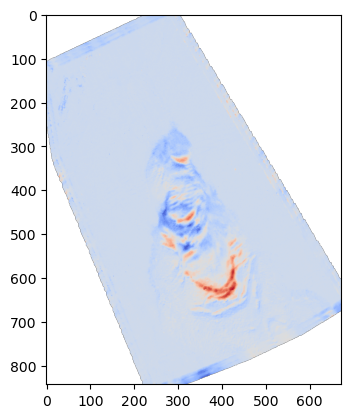

In [37]:
%matplotlib inline
plt.imshow(als_diff, cmap='coolwarm')
plt.show()

In [38]:
als_diff_file = 'als_diff.tif'

with rio.open(als_diff_file, 'w', **dsm_meta) as ff:
    ff.write(als_diff, 1)

### 4. Compare results of surface change detection: ULS vs ALS

We have now calculated the detected change in the rock glacier from ULS data and estimated the detected change if we had flown an ALS acquisition. By comparing the amount of change detected between ULS and ALS, we can determine whether an ALS acquisition would have been sufficient to detect surface change using our rudimentary method.

First, we open and plot the two DTMs representing the amount of surface change next to eachother for a visual comparison.

In [39]:
with rio.open(uls_diff_file) as src:
    uls_diff = src.read(1, masked=True)
    dsm_meta = src.profile

with rio.open(als_diff_file) as src:
    als_diff = src.read(1, masked=True)
    dsm_meta = src.profile

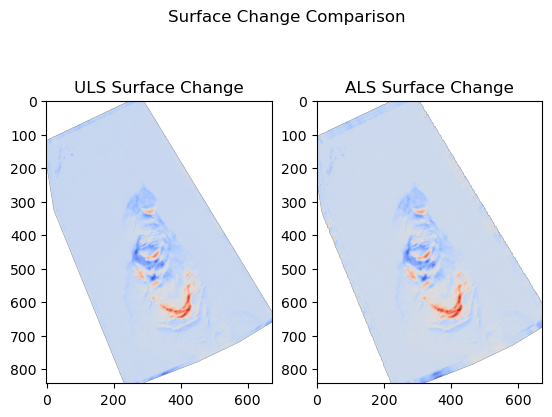

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Surface Change Comparison')

ax1.imshow(uls_diff, cmap='coolwarm')
ax1.set_title('ULS Surface Change')
ax2.imshow(als_diff, cmap='coolwarm')
ax2.set_title('ALS Surface Change');

The visual comparison did not reveal any major differences between the surface change detection. To gain a more detailed insight, we can calculate the difference of between the ULS difference and the ALS difference rasters. Thereby we can find out exactly by how much the ALS change detection differs from the change detection with the ULS data.

In [41]:
change_det_diff = uls_diff - als_diff

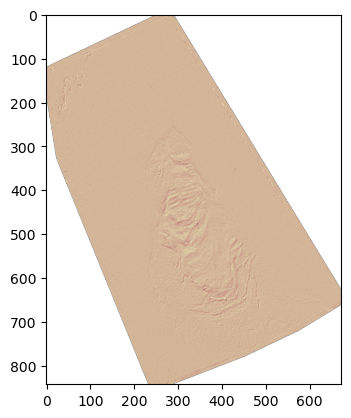

In [42]:
plt.imshow(change_det_diff, cmap='pink')
plt.show()

Next, we can calculate some statistics for the differences between the ULS and ALS change detection.

In [43]:
print(f'Maximum difference in detected surface change: {np.nanmax(np.abs(change_det_diff)):.3f} m')
print(f'Median absolute difference in detected surface change: {np.nanmedian(np.abs(change_det_diff)):.3f} m')
print(f'Arithmetic mean of absolute difference in detected surface change: {np.nanmean(np.abs(change_det_diff)):.3f} m')
# print(f'Q1 quantile of difference in detected surface change: {np.nanquantile(change_det_diff, 0.25)}m')
print(f'Q2 quantile of difference in detected surface change: {np.nanquantile(change_det_diff, 0.75):.3f} m')

Maximum difference in detected surface change: 5.123 m
Median absolute difference in detected surface change: 0.309 m
Arithmetic mean of absolute difference in detected surface change: 0.165 m
Q2 quantile of difference in detected surface change: 0.025 m


D:\Software\micromamba\envs\etrainee_m3\Lib\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
D:\Software\micromamba\envs\etrainee_m3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


As we can see, small overall differences in the detected magnitude do exist between the ALS and ULS surface change detection.

### 5. Results

<details>
    <summary>
        <b>Answer the following questions:</b> <br>
        1. Is ALS data sufficient for conducting our surface change analysis?
        <br>
        2. Repeat: What is the advantage of conducting ALS vs. ULS acquisitions?
        <br>
    Have another look at the plots and the statistics and try to answer the questions. For our answer, click on this text.
    </summary>
  
  ### Answer
  We found that the lower density point clouds from ALS provided a similar amount of information about the **areas** of surface change but yielded slightly higher inaccuracies regarding the **magnitudes** of surface change. We can therefore conclude that lower point density point clouds, such as those delivered by ALS acquisitions of the rock glacier, would be sufficient to **detect the areas** where surface change has occurred, whereas ULS data with higher spatial resolution would be required to accurately **measure the magnitudes** of the change. Because ALS acquisitions can cover **larger areas** than ULS, and because ALS data are increasingly available online through **national inventory databases**, ALS can be a **cost-effective** data source, especially for monitoring large study sites. For **smaller study sites** requiring **high resolution** data with potentially **specific acquisition setups** and **short acquisition intervals**, ULS will be the acquisition method of choice.

In addition, we have to take into account that some of the differences between the surface change derived from simulated ALS data and real-world ULS data can also be attributed to errors introduced during the DTM generation and LiDAR simulation steps.
</details>

**Bonus questions:**

1. Can you think of other methods of surface change detection?
2. Do you think ALS point clouds would be sufficient for these methods?